In [21]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))

from matplotlib import pyplot as plt
import numpy as np
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import msh_parser
from dg_maxwell import advection_2d
from dg_maxwell import global_variables as gvar
from dg_maxwell import utils
from dg_maxwell import advection_2d_arbit_mesh as a2d_arbit_mesh
from dg_maxwell import wave_equation_2d

af.set_backend(params.backend)
af.set_device(params.device)

plt.rcParams['figure.figsize']     = 12, 7.5
plt.rcParams['lines.linewidth']    = 1.5
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.weight']        = 'bold'
plt.rcParams['font.size']          = 20  
plt.rcParams['font.sans-serif']    = 'serif'
plt.rcParams['text.usetex']        = True
plt.rcParams['axes.linewidth']     = 1.5
plt.rcParams['axes.titlesize']     = 'medium'
plt.rcParams['axes.labelsize']     = 'medium'

plt.rcParams['xtick.major.size']   = 8
plt.rcParams['xtick.minor.size']   = 4
plt.rcParams['xtick.major.pad']    = 8
plt.rcParams['xtick.minor.pad']    = 8
plt.rcParams['xtick.color']        = 'k'
plt.rcParams['xtick.labelsize']    = 'medium'
plt.rcParams['xtick.direction']    = 'in'    

plt.rcParams['ytick.major.size']   = 8
plt.rcParams['ytick.minor.size']   = 4
plt.rcParams['ytick.major.pad']    = 8
plt.rcParams['ytick.minor.pad']    = 8
plt.rcParams['ytick.color']        = 'k'
plt.rcParams['ytick.labelsize']    = 'medium'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['text.usetex']        = True
plt.rcParams['text.latex.unicode'] = True

In [22]:
params.mesh_file = '../read_and_plot_mesh/mesh/square_10_10.msh'
advec_var = gvar.advection_variables(params.N_LGL, params.N_quad,
                                     params.x_nodes, params.N_Elements,
                                     params.c, params.total_time, params.wave,
                                     params.c_x, params.c_y, params.courant,
                                     params.mesh_file, params.total_time_2d)
new_elements = msh_parser.rearrange_element_edges(advec_var.elements, advec_var)
advec_var.reassign_2d_elements(new_elements)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


gmshTranslator: Initializing...
gmshTranslator: Mesh has 441 nodes.
gmshTranslator: Mesh has 144 elements.
gmshTranslator: Processed 589 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements
advection_variables __init__ completed


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


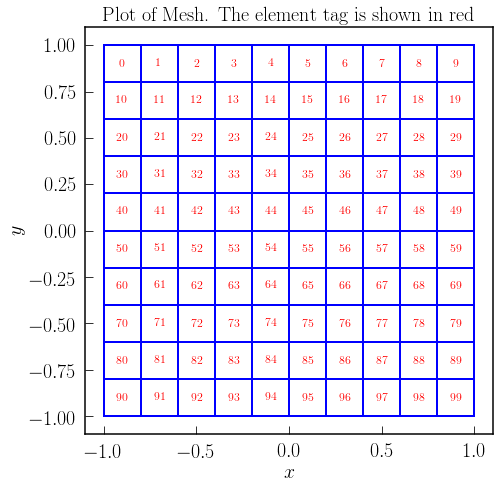

In [10]:
axes_handler = plt.axes()


msh_parser.plot_mesh_grid(advec_var.nodes, advec_var.elements,
                          advec_var.xi_LGL, advec_var.eta_LGL,
                          axes_handler, plot_LGL_grid = False,
                          print_element_tag = True)

plt.title(r'Plot of Mesh. The element tag is shown in red')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axes().set_aspect('equal')

plt.savefig('square.png')
plt.show()

In [23]:
u_e_ij = advec_var.x_e_ij

In [30]:
def upwind_flux_x(left_state, right_state):
    '''
    '''
    E_z = 0.5 * (right_state[:, :, 0] + left_state[:, :, 0] + right_state[:, :, 2] - left_state[:, :, 2])
    B_y = 0.5 * (right_state[:, :, 0] - left_state[:, :, 0] + right_state[:, :, 2] + left_state[:, :, 2])
    B_x = 0.5 * (right_state[:, :, 1] + left_state[:, :, 1])

    flux = af.constant(0.,
                       d0 = left_state.shape[0],
                       d1 = left_state.shape[1],
                       d2 = left_state.shape[2],
                       dtype = af.Dtype.f64)

    flux[:, :, 0] = - B_y
    flux[:, :, 2] = - E_z
    
    return flux

def upwind_flux_x(bottom_state, top_state):
    '''
    '''
    E_z = 0.5 * (bottom_state[:, :, 0] + top_state[:, :, 0] + bottom_state[:, :, 1] - top_state[:, :, 1])
    B_y = 0.5 * (bottom_state[:, :, 2] + top_state[:, :, 2])
    B_x = 0.5 * (bottom_state[:, :, 0] - top_state[:, :, 0] + bottom_state[:, :, 1] + top_state[:, :, 1])

    flux = af.constant(0.,
                       d0 = bottom_state.shape[0],
                       d1 = bottom_state.shape[1],
                       d2 = bottom_state.shape[2],
                       dtype = af.Dtype.f64)

    flux[:, :, 0] = B_x
    flux[:, :, 1] = E_z
    
    return flux


In [37]:
## Create 4 arrays to store the u_e_ij of the edges

# Left edge

left_edge_id = 0
u_left = a2d_arbit_mesh.u_at_edge(u_e_ij,
                                  edge_id = left_edge_id,
                                  advec_var = advec_var)

# Bottom edge
bottom_edge_id = 1
u_bottom = a2d_arbit_mesh.u_at_edge(u_e_ij,
                                    edge_id = bottom_edge_id,
                                    advec_var = advec_var)

# Right edge
right_edge_id = 2
u_right = a2d_arbit_mesh.u_at_edge(u_e_ij,
                                   edge_id = right_edge_id,
                                   advec_var = advec_var)

# Top edge
top_edge_id = 3
u_top = a2d_arbit_mesh.u_at_edge(u_e_ij,
                                 edge_id = top_edge_id,
                                 advec_var = advec_var)

# Create u_edge_vec
u_edge_vec = af.constant(0., d0 = params.N_LGL,
                         d1 = advec_var.elements.shape[0],
                         d2 = 4, dtype = af.Dtype.f64)
u_edge_vec[:, :, 0] = u_left
u_edge_vec[:, :, 1] = u_bottom
u_edge_vec[:, :, 2] = u_right
u_edge_vec[:, :, 3] = u_top

## Create 4 arrays to store the u_edge of the other edge sharing element

# Left edge

u_left_other_element = a2d_arbit_mesh.u_at_other_element_edge(u_edge_vec = u_edge_vec,
                                                              element_edge_id = left_edge_id,
                                                              advec_var = advec_var)

# Bottom edge
u_bottom_other_element = a2d_arbit_mesh.u_at_other_element_edge(u_edge_vec = u_edge_vec,
                                                                element_edge_id = bottom_edge_id,
                                                                advec_var = advec_var)

# Right edge
u_right_other_element = a2d_arbit_mesh.u_at_other_element_edge(u_edge_vec = u_edge_vec,
                                                               element_edge_id = right_edge_id,
                                                               advec_var = advec_var)

# Top edge
u_top_other_element = a2d_arbit_mesh.u_at_other_element_edge(u_edge_vec = u_edge_vec,
                                                             element_edge_id = top_edge_id,
                                                             advec_var = advec_var)

# [VALUES NOT TESTED]

# Find the LF flux for each edge

# Left edge

flux_left = wave_equation_2d.F_x(u_left)
flux_left_other_element = wave_equation_2d.F_x(u_left_other_element)

flux_bottom = wave_equation_2d.F_y(u_bottom)
flux_bottom_other_element = wave_equation_2d.F_y(u_bottom_other_element)

flux_right = wave_equation_2d.F_x(u_right)
flux_right_other_element = wave_equation_2d.F_x(u_right_other_element)

flux_top = wave_equation_2d.F_y(u_top)
flux_top_other_element = wave_equation_2d.F_y(u_top_other_element)

# print(af.transpose(flux_bottom_other_element))

# lf_flux_left_edge   = reiman_flux_lr(left_state = flux_left_other_element,
#                                      right_state = flux_left)
# lf_flux_bottom_edge = reiman_flux_ud(bottom_state = flux_bottom_other_element,
#                                      top_state = flux_bottom)
# lf_flux_right_edge  = reiman_flux_lr(left_state = flux_right,
#                                      right_state = flux_right_other_element)
# lf_flux_top_edge    = reiman_flux_ud(bottom_state = flux_left_other_element,
#                                      top_state = flux_left)

# element_lf_flux = af.constant(0, d0 = params.N_LGL,
#                               d1 = advec_var.elements.shape[0],
#                               d2 = 4, dtype = af.Dtype.f64)

# element_lf_flux[:, :, left_edge_id]   = lf_flux_left_edge
# element_lf_flux[:, :, bottom_edge_id] = lf_flux_bottom_edge
# element_lf_flux[:, :, right_edge_id]  = lf_flux_right_edge
# element_lf_flux[:, :, top_edge_id]    = lf_flux_top_edge

# element_lf_flux = af.reorder(element_lf_flux, d0 = 1, d1 = 2, d2 = 0)

# print(element_lf_flux.shape)


arrayfire.Array()
Type: double

[100 8 1 1]
   -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000 
   -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000 
   -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000 
   -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000 
   -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
   -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000 